<a href="https://colab.research.google.com/github/preetam01/M.Tech-Dissertation/blob/main/Twitter_Sentiment_Analysis_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **# Twitter Sentiment Analysis**(Using CNN)

# **# 1. Import Libraries/Dataset**


In [ ]:
# DataFrame
import pandas as pd

#Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_hub as hub
from tensorflow.keras.optimizers import Adam

# Scikit-learn
from sklearn.model_selection import train_test_split


# Utility
import re
import numpy as np
import matplotlib.pyplot as plt # Import matplotlib for data visualisation
from sklearn.metrics import confusion_matrix


In [ ]:
# DATASET
DATASET_COLUMNS = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"


# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"


**#. Import Data Set for Sentiment Analysis using Googe Drive (Below is the backup option in case kaggle API having issues to load data.

In [ ]:
# Code to read csv file into Colaboratory:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
#dataset = pd.read_csv(r"/content/drive/My Drive/Deep Learning/Kaggle Sentiment140.csv",encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

**#. Import Data Set for Sentiment Analysis directly from Kaggle**

In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!ls ~/.kaggle

kaggle.json


In [ ]:
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!echo '{"username":"preetamkumar","key":"02e539250914c9fea2c057a45b87339b"}' > /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d kazanova/sentiment140 -p /content

sentiment140.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip \*.zip

Archive:  sentiment140.zip
replace training.1600000.processed.noemoticon.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: sentiment140.zip
error:  invalid response [sentiment]
replace training.1600000.processed.noemoticon.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: error:  invalid response [140.zip]
replace training.1600000.processed.noemoticon.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: training.1600000.processed.noemoticon.csv  


In [ ]:
dataset = pd.read_csv('training.1600000.processed.noemoticon.csv' , encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

In [ ]:
df = dataset

In [ ]:
#Selecting a sample for the testing purpose
df = df.sample(100000)
df = df.reset_index(drop=True)
dataset = df
print(len(dataset))

100000


In [ ]:
print(len(dataset))

100000


In [ ]:
dataset.head(5)

,sentiment,ids,date,flag,user,text
0,0,2003834160,Tue Jun 02 07:13:36 PDT 2009,NO_QUERY,fudgecrumpet,"@georgieboo i used to love atmosfear, but gem ..."
1,0,1990063038,Mon Jun 01 03:45:30 PDT 2009,NO_QUERY,SarahMarie517,"I am a lobster...seriously, got sooooo burned ..."
2,0,1550683148,Sat Apr 18 06:56:05 PDT 2009,NO_QUERY,PLSED,Good morning. On my way to the funeral of a go...
3,0,1988739738,Sun May 31 23:14:02 PDT 2009,NO_QUERY,rl212007,is going to pretend to be storm chasing on Tue...
4,4,1981819096,Sun May 31 09:57:28 PDT 2009,NO_QUERY,singin_sunshine,i'm listening to ABBA http://bit.ly/pYs8b


In [ ]:
# Removing the unnecessary columns.
dataset = dataset.drop(columns = ["ids", "date", "flag", "user"])

In [ ]:
dataset.head(5)

,sentiment,text
0,0,"@georgieboo i used to love atmosfear, but gem ..."
1,0,"I am a lobster...seriously, got sooooo burned ..."
2,0,Good morning. On my way to the funeral of a go...
3,0,is going to pretend to be storm chasing on Tue...
4,4,i'm listening to ABBA http://bit.ly/pYs8b


# **# 2. Data Visualization**

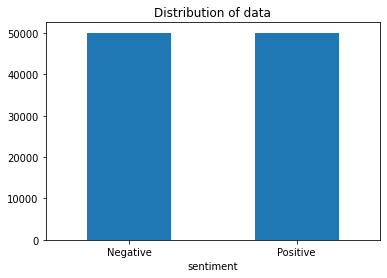

In [ ]:
# Replacing the values to ease understanding.
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

# Plotting the distribution for dataset.
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

# Storing data in lists.
text, sentiment = list(dataset['text']), list(dataset['sentiment'])

In [ ]:
dataset.sentiment.unique()

array([0, 1])

In [ ]:
dataset.groupby('sentiment').nunique()

,text
sentiment,
0,49939
1,49816


In [ ]:
print ("No of postive sentiment tweets:")
n_positive = len(dataset[dataset['sentiment'] == 1])
print(n_positive)

No of postive sentiment tweets:
49907


In [ ]:
print ("No of negative sentiment tweets:")
n_negative = len(dataset[dataset['sentiment'] == 0])
print(n_negative)

No of negative sentiment tweets:
50093


In [ ]:
# Print at least 2 tweets from each class of data set for the sanity check that labels match the text
# Print +ve reviws
print('Print at least 2 tweets from positive sentiment:')
dataset_pos = dataset[dataset['sentiment'] == 1]
dataset_pos.head(5)

Print at least 2 tweets from positive sentiment:


,sentiment,text
4,1,i'm listening to ABBA http://bit.ly/pYs8b
6,1,@mileycyrus http://twitpic.com/3pf7v - wow coo...
7,1,google voice is nice for us #oldtimers from th...
10,1,@sasssy_thang Get 100 followers a day using ww...
13,1,@Amy_BabyGirl bye amy don't work too hard


In [ ]:
# Print at least 2 tweets from each class of data set for the sanity check that labels match the text
# Print -ve reviws
print('Print at least 2 tweets from negative sentiment:')
dataset_neg = dataset[dataset['sentiment'] == 0]
dataset_neg.head(5)

Print at least 2 tweets from negative sentiment:


,sentiment,text
0,0,"@georgieboo i used to love atmosfear, but gem ..."
1,0,"I am a lobster...seriously, got sooooo burned ..."
2,0,Good morning. On my way to the funeral of a go...
3,0,is going to pretend to be storm chasing on Tue...
5,0,Its not the same watching the cats play withou...


# **#3. Data Pre-processing**

In [ ]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}


In [ ]:
#Removing Twitter Handles(@user)
#User Defined function to remove patten
#Removing Twitter Handles(@user)
#User Defined function to remove patten
#Removing Emojis

def preprocess(tweet):
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
        
                  
    # Replace all URls with 'URL'
    tweet = re.sub(urlPattern,' URL',tweet)
     # Replace all emojis.
    for emoji in emojis.keys():
        tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
    # Replace @USERNAME to 'USER'.
    tweet = re.sub(userPattern,' USER', tweet)        
    # Replace all non alphabets.
    tweet = re.sub(alphaPattern, " ", tweet)
    
    return tweet

In [ ]:
dataset['text'] = dataset['text'].apply(preprocess)

In [ ]:
dataset1 = dataset
dataset.head(5)


,sentiment,text
0,0,USER i used to love atmosfear but gem says i...
1,0,I am a lobster seriously got sooooo burned ...
2,0,Good morning On my way to the funeral of a go...
3,0,is going to pretend to be storm chasing on Tue...
4,1,i m listening to ABBA URL


In [ ]:
def preprocess_2(tweet):
      sequencePattern   = r"(.)\1\1+"
      tweet = re.sub('www',' ', tweet)   
      tweet = re.sub('WWW',' ', tweet)
      tweet = re.sub('USER',' ', tweet)
      tweet = re.sub('user',' ', tweet)
      tweet = re.sub('URL',' ', tweet)
      tweet = re.sub('url',' ', tweet)    
       # Replace 3 or more consecutive letters by ' '.
      tweet = re.sub(sequencePattern,' ',  tweet)
      return tweet

In [ ]:
dataset['text'] = dataset['text'].apply(preprocess_2)

In [ ]:
dataset.head(5)

,sentiment,text
0,0,i used to love atmosfear but gem says i m no...
1,0,I am a lobster seriously got s burned today ...
2,0,Good morning On my way to the funeral of a go...
3,0,is going to pretend to be storm chasing on Tue...
4,1,i m listening to ABBA


#**#4.Model Building**


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset.text, dataset.sentiment, test_size=0.2, random_state=37)
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 80000
# Test data samples: 20000


In [ ]:
#Print the head to check the X_train dataset
X_train.head(5)

45029    After 2 years  found out that I have a small s...
97602              My cooking can t compete with pancakes 
68872    is back from dominican republic  and is now mi...
28951    home  exhausted  but was great to see and this...
98026     I know  I watched that a couple if nights ago...
Name: text, dtype: object

> a) Sequential Model Layer - Use of 3 dense layers with appropriate input for each. 


In [ ]:
hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2", output_shape=[128], 
                           input_shape=[], dtype=tf.string)
model_1 = keras.Sequential()
model_1.add(hub_layer)
model_1.add(keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.0001)))
model_1.add(keras.layers.Dropout(0.5))
model_1.add(keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.0001)))

model_1.add(keras.layers.Dense(1, activation='sigmoid'))

model_1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dense_9 (Dense)              (None, 512)               66048     
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 257       
Total params: 124,840,321
Trainable params: 197,633
Non-trainable params: 124,642,688
_________________________________________________________________


#**#5.Model Compilation**

In [ ]:
# a) Compile the model with appropriate loss function 
### lost function used : BinaryCrossentropy 
# b) Use an appropriate optimizer. - "Adam" optimizer is used so that Adam combines the 
#    best properties of the AdaGrad and RMSProp algorithms to provide an optimization algorithm that can handle sparse gradients and no need
#    to define learning rate manually.

opt = Adam(lr=0.01)
model_1.compile(optimizer = opt, loss ='binary_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


#**#6.Model Training**

In [ ]:
no_of_epcohs = 15
gradient_batch_size = 128

history1 = model_1.fit(X_train, 
                   y_train,
                   validation_split = 0.2,
                   steps_per_epoch = 5,
                   epochs=no_of_epcohs,
                   batch_size=gradient_batch_size, verbose = 1)

Epoch 1/15
5/5 [==============================] - 1s 132ms/step - loss: 0.7830 - accuracy: 0.5188 - val_loss: 0.7589 - val_accuracy: 0.5039
Epoch 2/15
5/5 [==============================] - 0s 89ms/step - loss: 0.7052 - accuracy: 0.5844 - val_loss: 0.6812 - val_accuracy: 0.6611
Epoch 3/15
5/5 [==============================] - 1s 165ms/step - loss: 0.6739 - accuracy: 0.6625 - val_loss: 0.6473 - val_accuracy: 0.6895
Epoch 4/15
5/5 [==============================] - 0s 90ms/step - loss: 0.6803 - accuracy: 0.6594 - val_loss: 0.6447 - val_accuracy: 0.6932
Epoch 5/15
5/5 [==============================] - 1s 164ms/step - loss: 0.6295 - accuracy: 0.7156 - val_loss: 0.6339 - val_accuracy: 0.6933
Epoch 6/15
5/5 [==============================] - 0s 91ms/step - loss: 0.6230 - accuracy: 0.6938 - val_loss: 0.6220 - val_accuracy: 0.6988
Epoch 7/15
5/5 [==============================] - 0s 91ms/step - loss: 0.6432 - accuracy: 0.6859 - val_loss: 0.6183 - val_accuracy: 0.7056
Epoch 8/15
5/5 [========

In [ ]:

def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss N/A')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

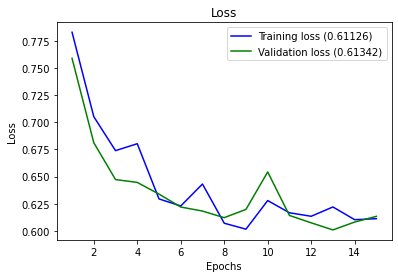

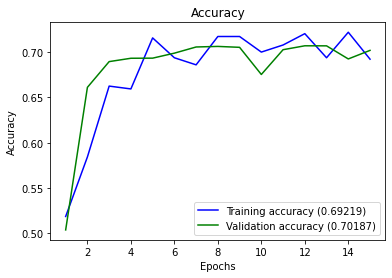

In [ ]:
plot_history(history1)

#**#7.Model Evaluation**

In [ ]:
#Step7 Evaluate Model
test_loss, test_acc = model_1.evaluate(X_test,  y_test, verbose=2)
print('\nTest accuracy:', test_acc)

625/625 - 2s - loss: 0.6019 - accuracy: 0.7101

Test accuracy: 0.710099995136261


In [ ]:
# Confusion Matrix 

# Predict the values from the validation dataset
Y_pred = model_1.predict(X_test)  

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1) 

results = confusion_matrix(y_test, Y_pred_classes)
print(results)

[[10000     0]
 [10000     0]]


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
class_names = ['Postive', 'Negative']
print(classification_report(y_test, Y_pred_classes, target_names = class_names))

              precision    recall  f1-score   support

     Postive       0.50      1.00      0.67     10000
    Negative       0.00      0.00      0.00     10000

    accuracy                           0.50     20000
   macro avg       0.25      0.50      0.33     20000
weighted avg       0.25      0.50      0.33     20000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
Y_pred_classes


array([0, 0, 0, ..., 0, 0, 0])

#**#8.Hyperparameter Tuning**

**i)-Dropout: Change the position and value of dropout layer**

In [ ]:
hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2", output_shape=[128], 
                           input_shape=[], dtype=tf.string)
model_2 = keras.Sequential()
model_2.add(hub_layer)
model_2.add(keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.0001)))
model_2.add(keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.0001)))
model_2.add(keras.layers.Dropout(0.9))
model_2.add(keras.layers.Dense(1, activation='sigmoid'))

model_2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_4 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dense_12 (Dense)             (None, 512)               66048     
_________________________________________________________________
dense_13 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 257       
Total params: 124,840,321
Trainable params: 197,633
Non-trainable params: 124,642,688
_________________________________________________________________


In [ ]:
opt = Adam(learning_rate =0.01)
model_2.compile(optimizer = opt, loss ='binary_crossentropy', metrics=['accuracy'])


In [ ]:
no_of_epcohs = 15
gradient_batch_size = 128

history2 = model_2.fit(X_train, 
                   y_train,
                   validation_split = 0.2,
                   steps_per_epoch = 5,
                   epochs=no_of_epcohs,
                   batch_size=gradient_batch_size, verbose = 1)

Epoch 1/15
5/5 [==============================] - 1s 133ms/step - loss: 0.7601 - accuracy: 0.5344 - val_loss: 0.7123 - val_accuracy: 0.6056
Epoch 2/15
5/5 [==============================] - 0s 88ms/step - loss: 0.7560 - accuracy: 0.5547 - val_loss: 0.6790 - val_accuracy: 0.6750
Epoch 3/15
5/5 [==============================] - 1s 164ms/step - loss: 0.7112 - accuracy: 0.6156 - val_loss: 0.6664 - val_accuracy: 0.6758
Epoch 4/15
5/5 [==============================] - 0s 86ms/step - loss: 0.6734 - accuracy: 0.7063 - val_loss: 0.6510 - val_accuracy: 0.6931
Epoch 5/15
5/5 [==============================] - 1s 164ms/step - loss: 0.6392 - accuracy: 0.7109 - val_loss: 0.6410 - val_accuracy: 0.6987
Epoch 6/15
5/5 [==============================] - 1s 164ms/step - loss: 0.6574 - accuracy: 0.7125 - val_loss: 0.6405 - val_accuracy: 0.6991
Epoch 7/15
5/5 [==============================] - 0s 89ms/step - loss: 0.6247 - accuracy: 0.7250 - val_loss: 0.6610 - val_accuracy: 0.6756
Epoch 8/15
5/5 [=======

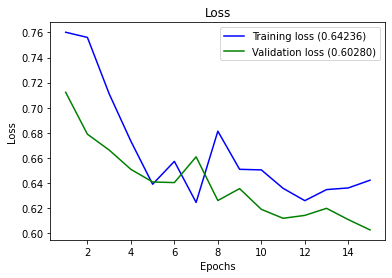

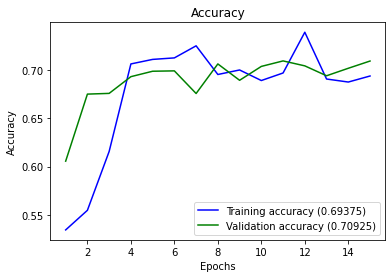

In [ ]:
plot_history(history2)

In [ ]:
# Model Evaluation
test_loss, test_acc = model_2.evaluate(X_test,  y_test, verbose=2)
print('\nTest accuracy:', test_acc)


625/625 - 2s - loss: 0.5940 - accuracy: 0.7186

Test accuracy: 0.7185500264167786


**ii)- Batch Size: Change the value of batch size in model training**

In [ ]:
hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2", output_shape=[128], 
                           input_shape=[], dtype=tf.string)
model_3 = keras.Sequential()
model_3.add(hub_layer)
model_3.add(keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.0001)))
model_3.add(keras.layers.Dropout(0.5))
model_3.add(keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.0001)))
model_3.add(keras.layers.Dense(1, activation='sigmoid'))

model_3.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_5 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dense_15 (Dense)             (None, 512)               66048     
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 257       
Total params: 124,840,321
Trainable params: 197,633
Non-trainable params: 124,642,688
_________________________________________________________________


In [ ]:
opt = Adam(lr=0.01)
model_3.compile(optimizer = opt, loss ='binary_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
no_of_epcohs = 15
gradient_batch_size = 32

history3 = model_3.fit(X_train, 
                   y_train,
                   validation_split = 0.2,
                   steps_per_epoch = 5,
                   epochs=no_of_epcohs,
                   batch_size=gradient_batch_size, verbose = 1)

Epoch 1/15
5/5 [==============================] - 2s 364ms/step - loss: 0.7666 - accuracy: 0.5312 - val_loss: 0.9562 - val_accuracy: 0.5146
Epoch 2/15
5/5 [==============================] - 1s 324ms/step - loss: 0.7876 - accuracy: 0.5562 - val_loss: 0.7144 - val_accuracy: 0.5564
Epoch 3/15
5/5 [==============================] - 1s 324ms/step - loss: 0.7060 - accuracy: 0.6375 - val_loss: 0.6791 - val_accuracy: 0.6689
Epoch 4/15
5/5 [==============================] - 1s 287ms/step - loss: 0.6359 - accuracy: 0.7000 - val_loss: 0.7464 - val_accuracy: 0.6399
Epoch 5/15
5/5 [==============================] - 1s 291ms/step - loss: 0.7249 - accuracy: 0.6250 - val_loss: 0.7201 - val_accuracy: 0.5966
Epoch 6/15
5/5 [==============================] - 1s 299ms/step - loss: 0.7423 - accuracy: 0.6187 - val_loss: 0.6904 - val_accuracy: 0.6556
Epoch 7/15
5/5 [==============================] - 1s 324ms/step - loss: 0.6765 - accuracy: 0.6812 - val_loss: 0.6739 - val_accuracy: 0.6766
Epoch 8/15
5/5 [====

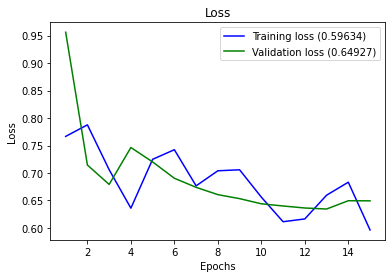

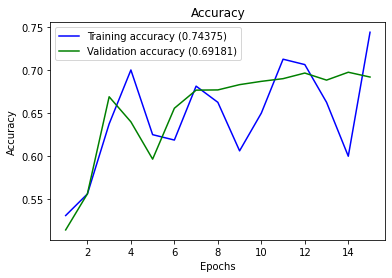

In [ ]:
plot_history(history3)

In [ ]:
# Model Evaluation
test_loss, test_acc = model_3.evaluate(X_test,  y_test, verbose=2)
print('\nTest accuracy:', test_acc)


625/625 - 1s - loss: 0.6442 - accuracy: 0.7012

Test accuracy: 0.7011500000953674


**# Comparision between models and reason for change is accuracy**

<table>
<body>

<tr><td><b>Model</td><td><b>Dropouts</td><td><b>Batch Size</td><td><b> Training Accuracy</td>
 <td><b>Testing Accuracy</td><td><b>Observation</td>
</tr>

<tr><td>Model_1</td><td align="center"><b>0.5</td><td align="center"><b>128</td><td align="center"><b>75.78%</td>
 <td align="center"><b>72.17%</td><td>
  <h7>This is the base model.<br>Training Accuracy and testing Accuracy is almost same. No overfitting or underfitting issues with the model. 
 </td>
</tr>

<tr><td>Model_2</td><td align="center"><b>0.9</td><td align="center"><b>128</td><td align="center"><b>74.69% </td>
 <td align="center"><b>71.10%</td><td><P1>
  <h7>Traning Accuracy and the Testing Accuracy is almost same. No overfiting or underfiting issues with the model. <br>Accuracy is getting less with high Dropouts parameter compare to the base model.
</td>
</tr>
<tr><td>Model_3</td><td align="center"><b>0.5</td><td align="center"><b>32</td><td align="center"><b>69.38%</td>
 <td align="center"><b>70.61%</td><td>
 <h7>
 Execution time is taking more time with less batch size compare to the base model with same Epoch. 
<br>Training accuracy is slightly more compare to the base model.<br> No overfitting or underfitting issues.
</h2>
</td>
</tr>
</body>
</table>

In [ ]:
# hub_layer3 = hub.KerasLayer(" http://nlp.stanford.edu/data/glove.twitter.100d.27B", output_shape=[100], 
#                            input_shape=[], dtype=tf.string)
# model_3 = keras.Sequential()
# model_3.add(hub_layer)
# model_3.add(keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.0001)))
# model_3.add(keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.0001)))
# model_3.add(keras.layers.Dropout(0.9))
# model_3.add(keras.layers.Dense(1, activation='sigmoid'))

# model_2.summary()